In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy import integrate
import matplotlib.cm as cm
import scipy
import scipy.optimize as opt
import astropy.units as u

import sys
sys.path.insert(0, '/Users/mariavincenzi/PhD/Photometry_Utils/')

import what_the_flux as wtf
import what_the_flux_2nd as wtf2


import astropy.constants as astro_const
import astropy.cosmology as cosmo

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel
FILTER_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Sullivan_Filters/"

import astropy.cosmology as cosmo
my_cosmo = cosmo.FlatLambdaCDM(H0=70*u.km/u.second/u.Mpc, Om0=0.3)

    
%matplotlib inline

In [2]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/data/"

color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue',
                'DES_g': "darkgreen",
                 'DES_r': "#F2990A",
                 'DES_i': "red",
                'DES_z': "darkred"}

In [3]:
import astropy.cosmology as cosmo
my_cosmo = cosmo.FlatLambdaCDM(H0=70*u.km/u.second/u.Mpc, Om0=0.3)
def dist_modulus_from_redshift(z):
    return my_cosmo.distmod(z).value
H0 = 70*u.km/u.second/u.Mpc

In [4]:
class GenerateLC():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, main_path, snname, verbose=False, twodim=True, hostcorr=True):

        ## Initialise the class variables
        self.main_path = main_path
        self.lc_data_path = main_path+'lc/'
        self.snname = snname  
        if hostcorr: hostcorr_suff =''
        elif not hostcorr: hostcorr_suff ='/HostNotCorr/'
        self.remangled_spec_data_path = main_path+'/results_template/%s/FINAL_spectra_2dim/'%self.snname+hostcorr_suff
        self.create_results_folder()
        
    def get_spec_list(self, verbose=False):

        onlyfiles = [f for f in os.listdir(self.remangled_spec_data_path) \
                         if os.path.isfile(os.path.join(self.remangled_spec_data_path, f)) 
                     if ('txt' in f)&('SNF' not in f)]
        return onlyfiles
    
    def load_remangled_spec(self, file_name):
        ext_spec = np.genfromtxt(self.remangled_spec_data_path+file_name,\
                                     dtype=None, encoding="utf-8", names=['wls', 'flux', 'flux_err'], usecols=[0,1,2])
        return ext_spec
    
    def band_flux(self, spec_wls_restframe, spec_flux, spec_flux_err, filter_name):
        
        spec_wls = spec_wls_restframe
    
        if 'swift' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/Swift/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        elif 'DES' in filter_name:
            filt_transm = np.genfromtxt(FILTER_PATH+'/DES/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        #elif self.snname in CSP_SNe:
        #    try:
        #        filt_transm = np.genfromtxt(FILTER_PATH+'/Site3_CSP/%s.txt'%filter_name,\
        #                                         dtype=None, encoding="utf-8", names=['wls', 'flux'])
        #        #print ('Im using the CSP NATURAL SYSTEM!!!')
        #    except IOError:
        #        filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
        #                                         dtype=None, encoding="utf-8", names=['wls', 'flux'])
                
        else:
            filt_transm = np.genfromtxt(FILTER_PATH+'/GeneralFilters/%s.dat'%filter_name,\
                                                 dtype=None, encoding="utf-8", names=['wls', 'flux'])
        
        filt_transm_interp_func = interpolate.interp1d(filt_transm['wls'], filt_transm['flux'], kind='linear')
        cut_spec = [(spec_wls>min(filt_transm['wls']))&\
                     (spec_wls<max(filt_transm['wls']))]
        cut_raw_spec_wls = spec_wls[cut_spec]
        cut_raw_spec_flx = spec_flux[cut_spec]
        cut_raw_spec_flx_err = spec_flux_err[cut_spec]

        filt_transm_interp = filt_transm_interp_func(cut_raw_spec_wls)
        filt_transm_interp_xLambda = filt_transm_interp*cut_raw_spec_wls

        raw_phot = integrate.trapz(filt_transm_interp_xLambda*cut_raw_spec_flx, cut_raw_spec_wls)/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec_wls)
        raw_phot_err = (integrate.trapz((filt_transm_interp_xLambda*cut_raw_spec_flx_err)**2, 
                                        cut_raw_spec_wls))**0.5/\
                 integrate.trapz(filt_transm_interp_xLambda, cut_raw_spec_wls)

        return raw_phot, raw_phot_err
    
    def get_remangled_photometry(self, f_list):
        dicts_LC_raw = {}
        spec_list = self.get_spec_list()
        
        for band in f_list:
            LC_raw = []
            LC_raw_err = []
            for file in (spec_list):
                remang_spec = self.load_remangled_spec(file)
                phot, phot_err = self.band_flux(remang_spec['wls'], remang_spec['flux'], 
                                                remang_spec['flux_err'], band)
                LC_raw.append(phot)
                LC_raw_err.append(phot_err)

            dicts_LC_raw[band] = {'time': (self.get_spec_mjd()), \
                                'flux': LC_raw, 'flux_err': LC_raw_err}
        if f_list==['Peak_Phase_filter']:
            return dicts_LC_raw
        else:
            self.dicts_LC_raw = dicts_LC_raw
            return dicts_LC_raw

    def get_spec_mjd(self):
        return np.array([float(f.replace('_FINAL_spec.txt', '').replace('_FINAL_spec_FL.txt', ''))\
                         for f in self.get_spec_list()])#

    def get_spec_mjd_fake(self):
        return np.array([float(f.replace('_FINAL_spec_FL.txt', ''))\
                         for f in self.get_spec_list() if 'FL' in f])#

    def get_avail_filt(self):
        lista = [band for band in self.original_phot.columns if ('_err' not in band)&('MJD' not in band)]
        self.avail_filters = lista
        return lista
        
    def LCfit_withGP_xfilter(self, filt, f_list, minMJD=None, maxMJD=None):
        if not hasattr(self, "dicts_LC_raw"):
            self.get_remangled_photometry(f_list)
        
        def ll(p):
            gp.set_parameter_vector(p)
            param_dict = gp.get_parameter_dict()
            if 'white_noise:value' in param_dict.keys():
                if (np.exp(param_dict['white_noise:value'])<10**-3): 
                    return np.inf
                else: return -gp.lnlikelihood(flux_norm, quiet=False)#
            else: return -gp.lnlikelihood(flux_norm, quiet=False)#

        # gradient of the  liklihood for optimisation of the kernel size
        def grad_ll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_lnlikelihood(flux_norm, quiet=False)
            
        if minMJD is None:
            minMJD= np.min(self.get_spec_mjd())
        if maxMJD is None:
            maxMJD= np.max(self.get_spec_mjd())

        LC_filt_extended = self.dicts_LC_raw[filt]

        new_mjd = LC_filt_extended['time']#np.arange(minMJD, maxMJD, 1.)
        mjd = LC_filt_extended['time']
        mjdT = np.atleast_2d(mjd).T
        
        flux = (LC_filt_extended['flux'])
        flux_err = LC_filt_extended['flux_err']
        
        norm = np.median(flux) #np.median(LC_filt_extended['flux']) 
        flux_norm = flux/norm
        err_flux_norm = flux_err/norm
        
        # if self.snname in Kernel_wNoise_wOpt:
        #     k= np.var(flux_norm)* Matern32Kernel(350.)
        #     gp = george.GP(k, white_noise=10**-10, fit_white_noise=True, fit_kernel=True)
        # elif self.snname in Kernel_noNoise_wOpt:
        #     k= np.var(flux_norm)* Matern32Kernel(50.)
        #     gp = george.GP(k, fit_kernel=True)
        # elif self.snname in Kernel_noNoise_noOpt:
        #     k= np.var(flux_norm)* ExpSquaredKernel(500.)
        #     gp = george.GP(k, fit_kernel=False)
        # elif self.snname in Kernel_wNoise_noOpt_LongScale:
        #     k= np.var(flux_norm)* Matern32Kernel(400.)
        #     gp = george.GP(k, white_noise=10**-10, fit_white_noise=True, fit_kernel=False)
        # else:
        #     print ('Specify Kernel')
    #print ('log_M_0_0', np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0']))
    ##print ('log_M_1_1', np.exp(param_dict['kernel:k1:k2:metric:log_M_1_1']))
    #if ((np.exp(param_dict['kernel:k1:k2:metric:log_M_0_0'])<0.00001)|(np.exp(param_dict['kernel:k1:k2:metric:log_M_1_1'])<0.00001)):
    #    print ('No good')
    #    return -np.inf

        #gp.compute(mjdT, err_flux_norm)
        #if self.snname not in Kernel_noNoise_noOpt:
        #    p0=gp.get_parameter_vector()
        #    results = opt.minimize(ll, p0, jac=grad_ll)
        #    print (filt, np.exp(results.x))
        #if 'DES' in filt:
        #    for n,v in zip(gp.get_parameter_names(), gp.get_parameter_vector()):
        #        if n=='white_noise:value': print (n, '%.2E'%np.exp(v))
        #
        #mu, cov = gp.predict(flux_norm, new_mjd)
        #std = np.sqrt(np.diag(cov))
        #mu = (mu*norm)
        #std =  std*norm
        mu = np.interp(new_mjd, mjd, flux)
        std = np.interp(new_mjd, mjd, flux_err)

        flux = (flux_norm*norm)
        err_flux =  (err_flux_norm*norm)
        
        mu[mu<=0.] = np.nan 
        std[mu<=0.] = np.nan 
           
        self.dicts_LC_gp[filt] = {'time':new_mjd, 'flux':mu, 'flux_err':std}
        return None
            

    def define_filters2fit(self, f_list=[]):
        if len(f_list)>0:
            self.avail_filters = f_list
        else:
            self.avail_filters = ['DES_g', 'DES_r', 'DES_i', 'DES_z']

    def LCfit_withGP(self, f_list=None, minMJD=None, maxMJD=None):
        if not hasattr(self, "dicts_LC_gp"):
            print ('Computing GP fit (for the first time)')
        else:
            print ('Forcing to do GP fit again')
        
        if not hasattr(self, "avail_filters"):
            self.define_filters2fit(f_list)

        self.dicts_LC_gp = {}
        for f in f_list:
            #print ('Interpolating with GPs ', f)
            self.LCfit_withGP_xfilter(f, f_list, minMJD=minMJD, maxMJD=maxMJD)
        return self.dicts_LC_gp
        
        
    def create_results_folder(self):
        results_directory = self.main_path+'/results_template/%s/LFunc_LC/'%self.snname
        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        self.results_mainpath = results_directory

    def dist_mod(self):
        load_info = np.genfromtxt(DATALC_PATH+'info/info.dat', dtype=None, names=True)
        sn_info = load_info[np.array(load_info['snname'], dtype=str)==self.snname]
        print (sn_info)
        z = sn_info['z_obs'][0]
        self.redshift = z
        self.dist_modulus = my_cosmo.distmod(z).value
        return self.dist_modulus      

    def Ftof(self):
        load_info = np.genfromtxt(DATALC_PATH+'info/info.dat', dtype=None, names=True)
        sn_info = load_info[np.array(load_info['snname'], dtype=str)==self.snname]
        z = sn_info['z_obs'][0]
        H0_conv = H0.to(u.cm/u.s/u.cm)
        c = astro_const.c.to(u.cm/u.s)
        self.Ftof_cm2 = 4*np.pi*((c*z)/H0_conv)**2
        return self.Ftof_cm2

In [5]:
#Kernel_wNoise_wOpt = ['SN2005cs', 'SN2013df', 'SN2012ap', 'SN2004fe', 'SN2011bm','SN2010al']
#Kernel_noNoise_wOpt = ['SN2007Y', 'SN2011ei', 'SN2011hs', 'SN2013am', 'SN2011fe']
#Kernel_noNoise_noOpt = ['SN2007pk']
#
#Kernel_wNoise_noOpt_LongScale = ['SN2006aj', 'SN2013fs', 'SN2014G', 'SN2013ge', 'SN1998bw', 
#                                 'SN2011dh', 'SN2013ej', 'SN2009ip', 'SN2008ax',
#                                 'SN2008aq', 'SN2007gr', 'iPTF13bvn', 'SN2009mg', 'SN1993J','SN2007uy', 'SN2013am']
#


Kernel_wNoise_wOpt = ['SN2013df', 'SN2012ap', 'SN2004fe', 'SN2011bm','SN2005cs','SN2008aq','SN2007pk','SN2007uy']
Kernel_noNoise_wOpt = ['SN2007Y', 'SN2011ei', 'SN2011hs', 'SN2011fe','SN2013am']
Kernel_noNoise_noOpt = []

Kernel_wNoise_noOpt_LongScale = ['SN2006aj', 'SN2013fs', 'SN2014G', 'SN2013ge', 'SN1998bw', 
                                 'SN2011dh', 'SN2013ej', 'SN2009ip', 'SN2008ax','SN2009bb',
                                  'SN2007gr', 'iPTF13bvn', 'SN2009mg', 'SN1993J', 'SN2013am',
                                'SN2012aw', 'SN1994I','SN2010al', 'SN2013ab','SN2009jf','SN2004fe','SN2002ap',
                                'SN2009N', 'SN2004et', 'SN2013by', 'SN2006bp', 'SN2007od', 'SN2008in', 
                                 'SN2006T', 'SN2004gq', 'SN1999em','SN1999dn', 'SN2005bf', 'SN2005hg',
        'SN2007ru', 'SN2008D', 'SN2008bj', 'SN2008fq',
        'SN2009bw', 'SN2004gv','SN2004gt', 'SN2009dd','SN2012A',
       'SN2016gkg','SN2006ep', 'SN2006aa','SN2016X', 'SN2011fu', 'SN2016bkv', 'SN2011ht', 'SN2012ap']

Kernel_wNoise_noOpt_LongScale=['ASASSN14jb', 'ASASSN15no', 'iPTF13bvn', 'SN1993J', 'SN1994I', 
           'SN1998bw', 'SN1999dn', 'SN1999em', 'SN2004aw', 
           'SN2004et', 'SN2004fe', 'SN2004gq', 'SN2004gt', 'SN2004gv', 
           'SN2005bf', 'SN2005cs', 'SN2005hg', 'SN2006aa', 'SN2006aj', 
           'SN2006ep', 'SN2006T', 'SN2007gr', 'SN2007od', 'SN2007pk', 
           'SN2007ru', 'SN2007Y', 'SN2008aq', 'SN2008ax', 
           'SN2008bj', 'SN2008D', 'SN2008fq', 'SN2008in', 
           'SN2009bb', 'SN2009bw', 'SN2009dd', 'SN2009ib', 'SN2009ip', 
           'SN2009iz', 'SN2009jf', 'SN2009kr', 'SN2009N', 'SN2010al', 
           'SN2011bm', 'SN2011dh', 'SN2011ei', 'SN2011fu', 'SN2011hs', 
           'SN2011ht', 'SN2012A', 'SN2012ap', 'SN2012aw', 'SN2013ab', 
           'SN2013am', 'SN2013by', 'SN2013df', 'SN2013ej', 'SN2013fs', 
           'SN2013ge', 'SN2014G', 'SN2016bkv', 'SN2016gkg', 'SN2016X']

In [6]:
Phase_grid = np.arange(-20.0, 62.0, 2.0)
flux_units = u.erg / (u.Angstrom * u.second * u.cm**2)

In [7]:

sn_list = ['ASASSN14jb', 'ASASSN15oz', 'iPTF13bvn', 'SN1993J', 'SN1994I', 
           'SN1998bw', 'SN1999dn', 'SN1999em', 'SN2002ap', 'SN2004aw', 
           'SN2004et', 'SN2004fe', 'SN2004gq', 'SN2004gt', 'SN2004gv', 
           'SN2005bf', 'SN2005cs', 'SN2005hg', 'SN2006aa', 'SN2006aj', 
           'SN2006ep', 'SN2006T', 'SN2007gr', 'SN2007od', 'SN2007pk', 
           'SN2007ru', 'SN2007uy', 'SN2007Y', 'SN2008aq', 'SN2008ax', 
           'SN2008bj', 'SN2008bo', 'SN2008D', 'SN2008fq', 'SN2008in', 
           'SN2009bb', 'SN2009bw', 'SN2009dd', 'SN2009ib', 'SN2009ip', 
           'SN2009iz', 'SN2009jf', 'SN2009kr', 'SN2009N', 'SN2010al', 
           'SN2011bm', 'SN2011dh', 'SN2011ei', 'SN2011fu', 'SN2011hs', 
           'SN2011ht', 'SN2012A', 'SN2012ap', 'SN2012aw', 'SN2013ab', 
           'SN2013am', 'SN2013by', 'SN2013df', 'SN2013ej', 'SN2013fs', 
           'SN2013ge', 'SN2014G', 'SN2016bkv', 'SN2016gkg', 'SN2016X', 'SN2012au']
notLBvri=False

In [8]:
len(sn_list)

66

ASASSN14jb
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


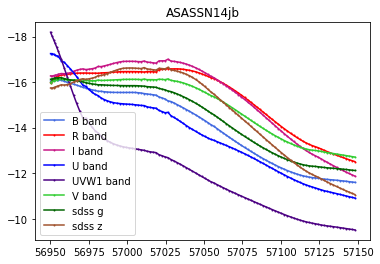

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


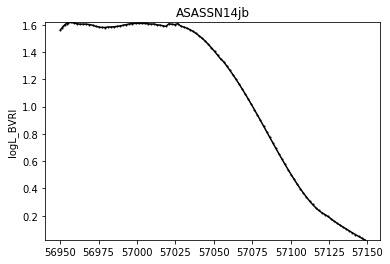

ASASSN15oz
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


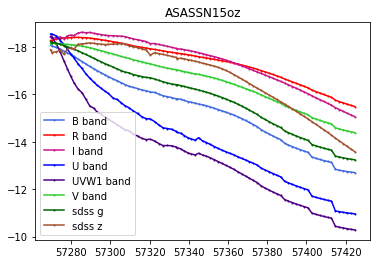

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


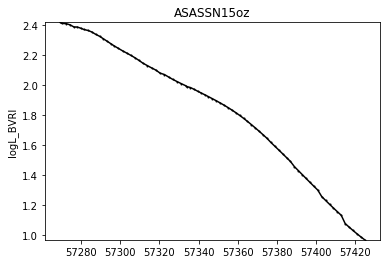

iPTF13bvn
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


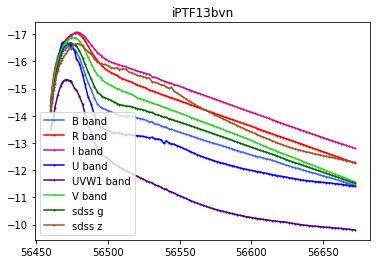

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


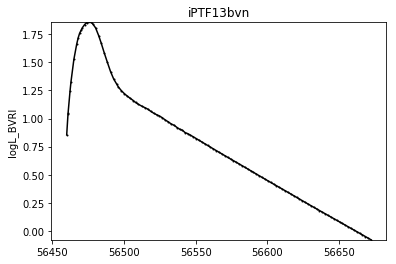

SN1993J
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


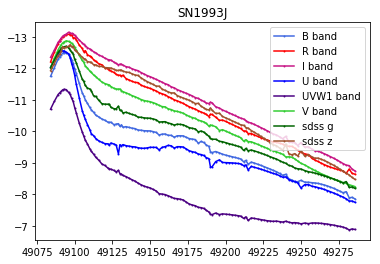

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


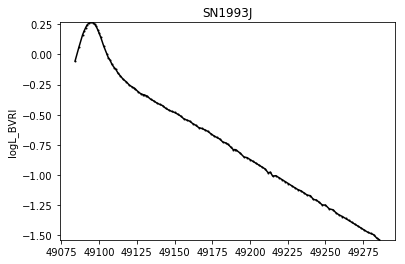

SN1994I
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


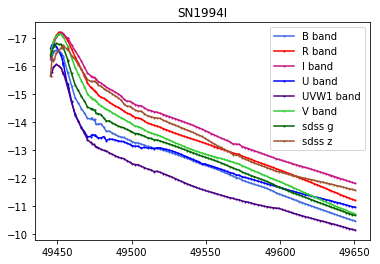

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


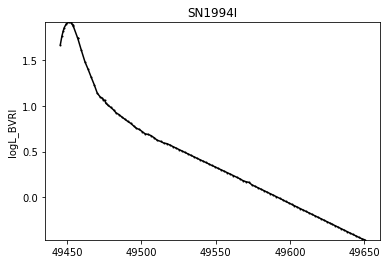

SN1998bw
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


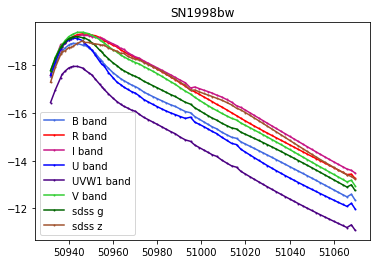

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


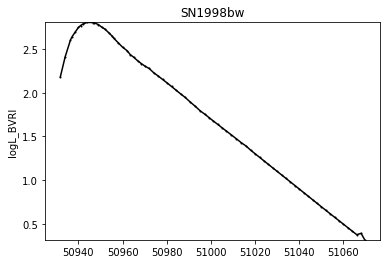

SN1999dn
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


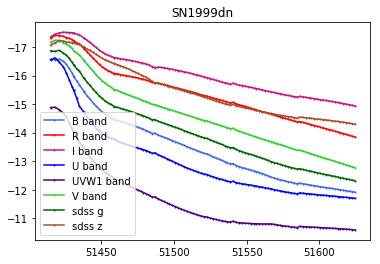

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


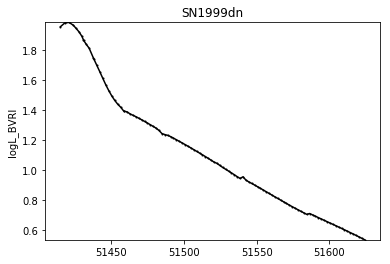

SN1999em
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


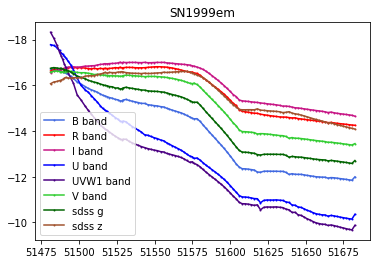

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


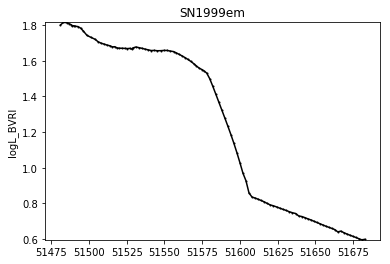

SN2002ap
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


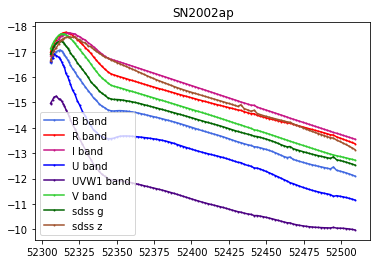

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


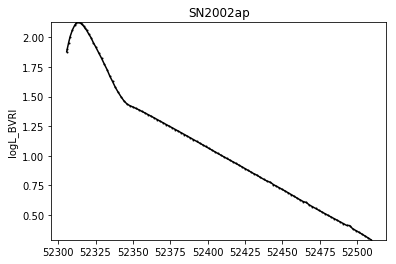

SN2004aw
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


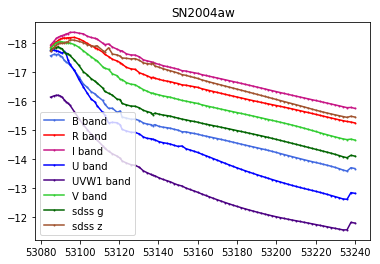

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


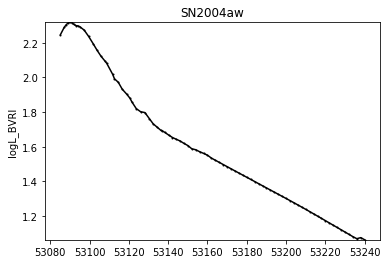

SN2004et
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


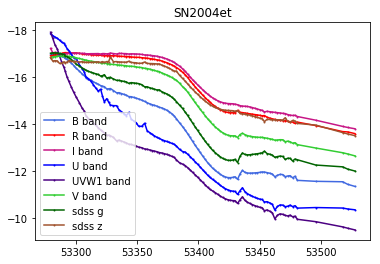

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


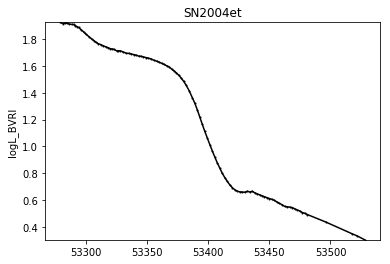

SN2004fe
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


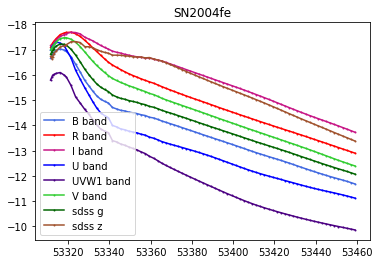

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


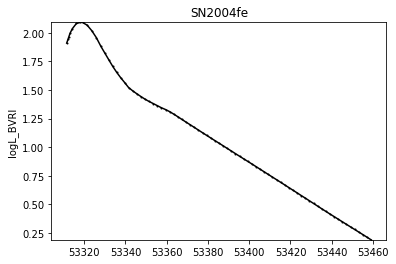

SN2004gq
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


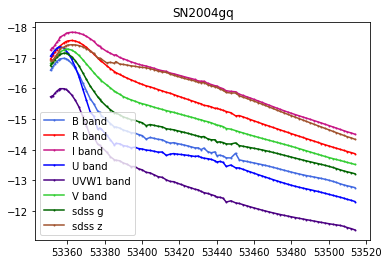

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


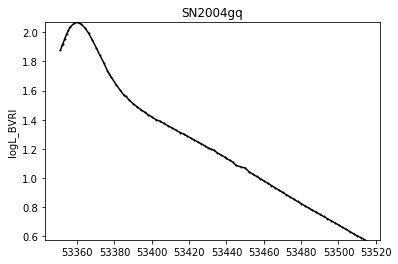

SN2004gt
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


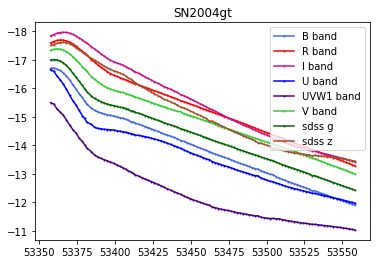

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


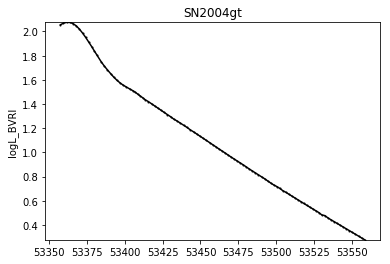

SN2004gv
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


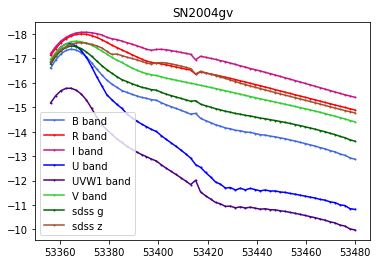

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


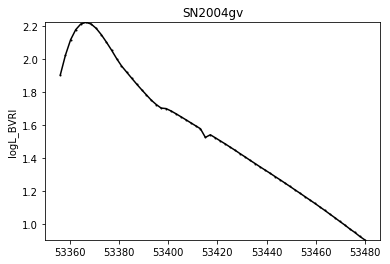

SN2005bf
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


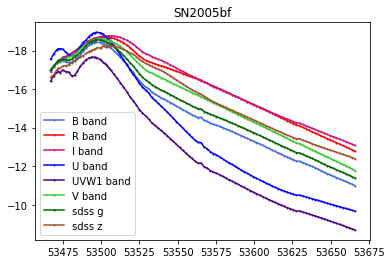

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


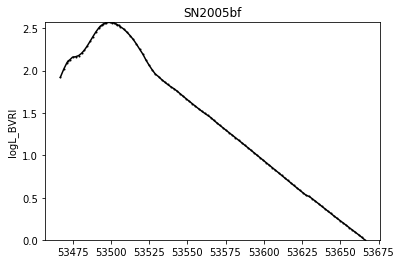

SN2005cs
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


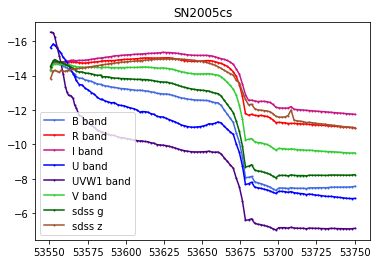

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


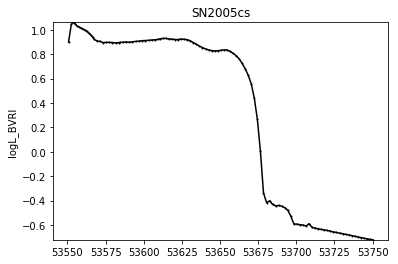

SN2005hg
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


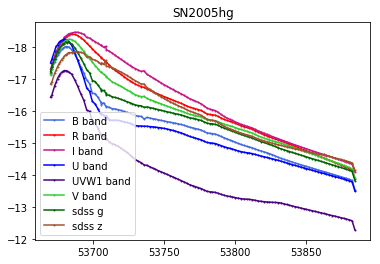

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


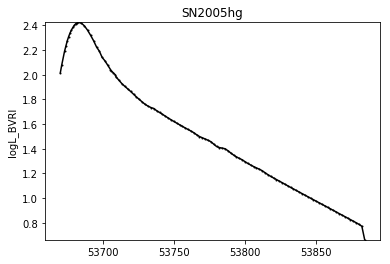

SN2006aa
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


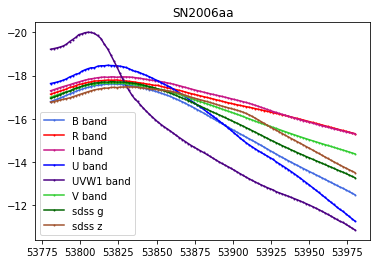

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


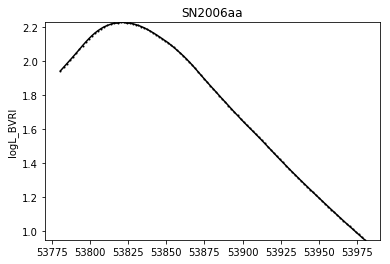

SN2006aj
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


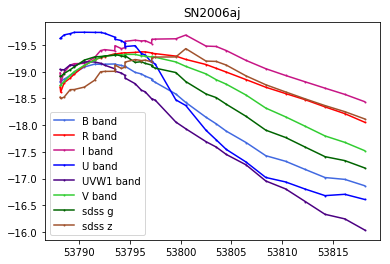

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


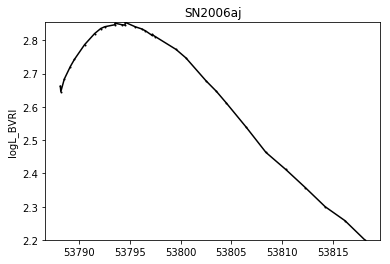

SN2006ep
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


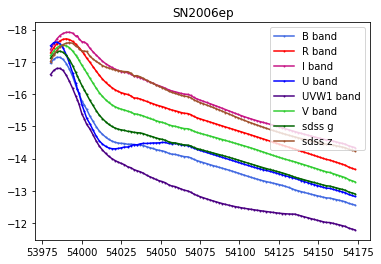

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


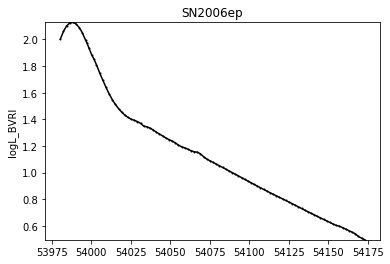

SN2006T
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


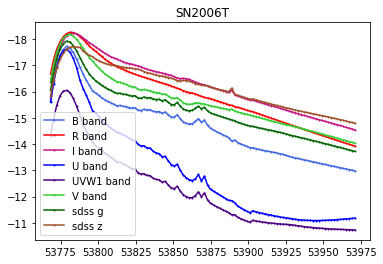

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


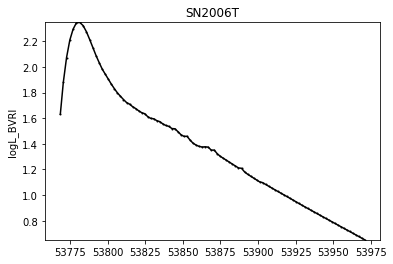

SN2007gr
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


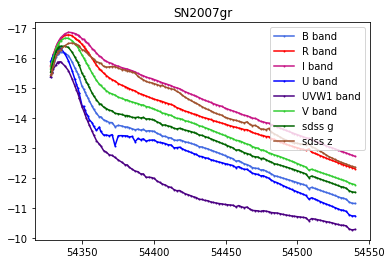

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


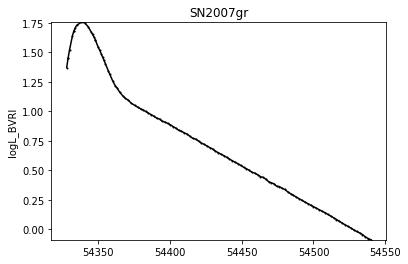

SN2007od
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


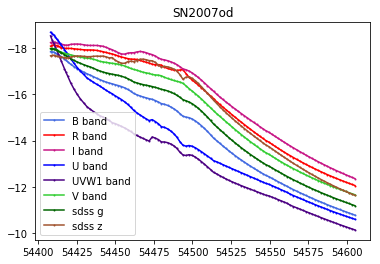

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


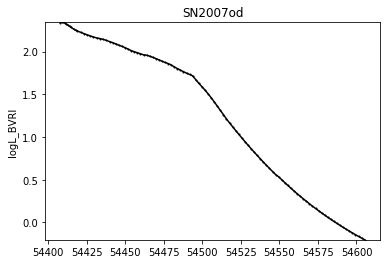

SN2007pk
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


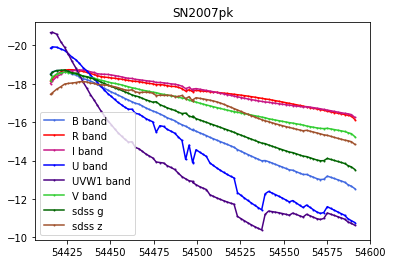

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


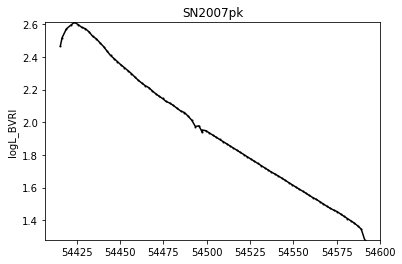

SN2007ru
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


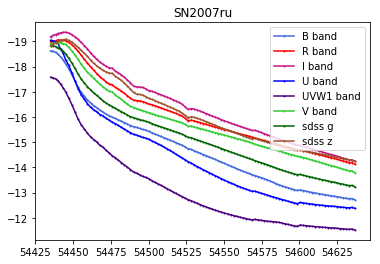

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


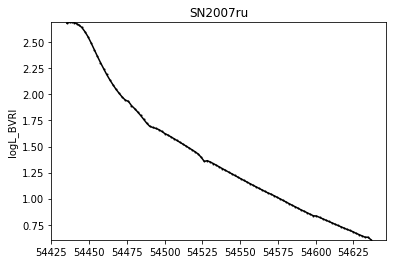

SN2007uy
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


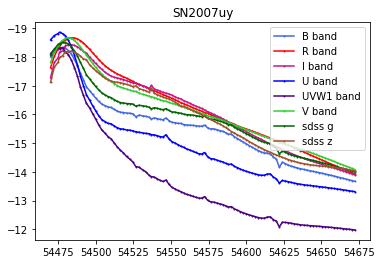

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


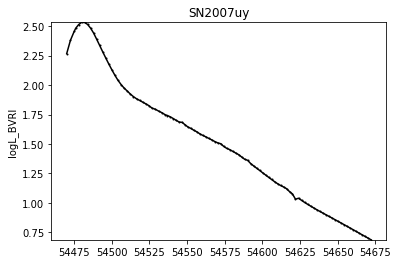

SN2007Y
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


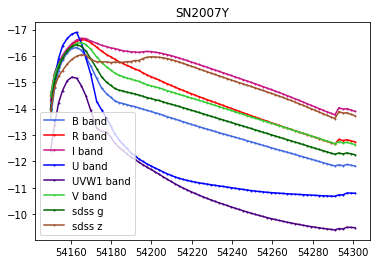

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


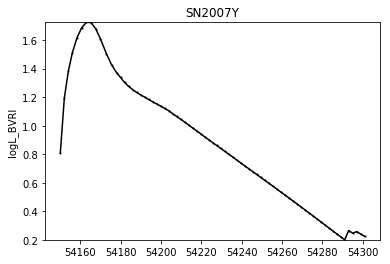

SN2008aq
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


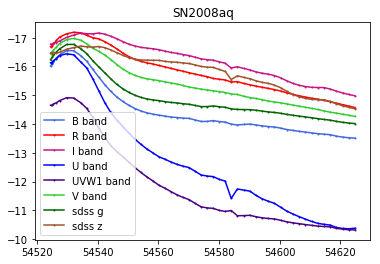

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


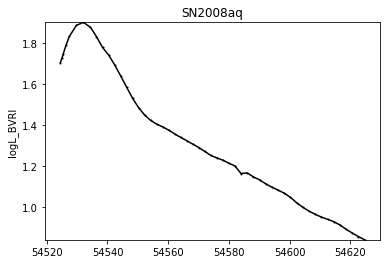

SN2008ax
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


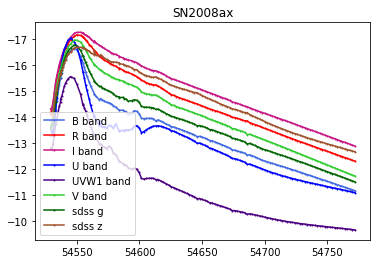

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


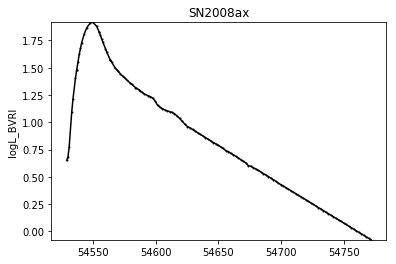

SN2008bj
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


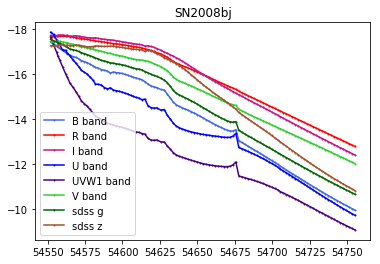

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


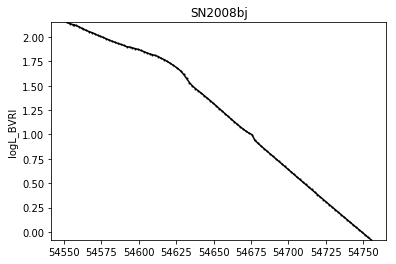

SN2008bo
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


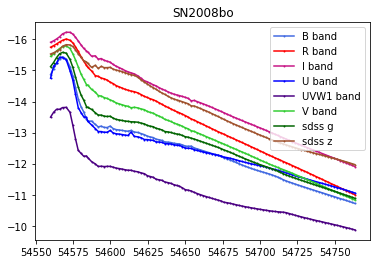

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


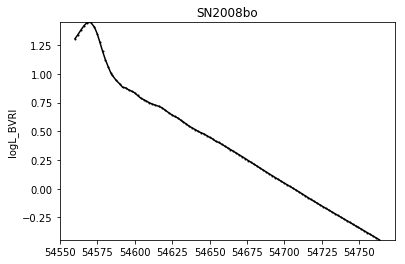

SN2008D
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


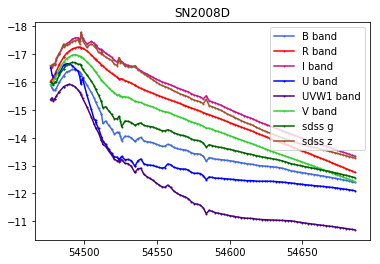

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


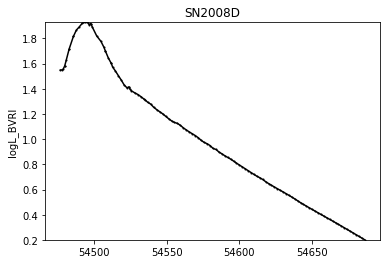

SN2008fq
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


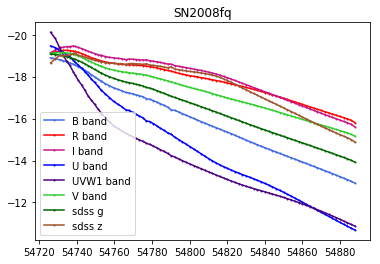

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


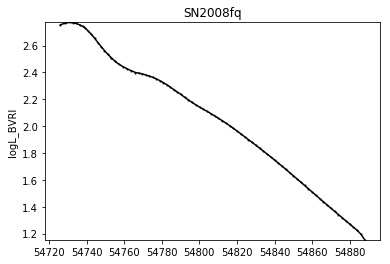

SN2008in
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


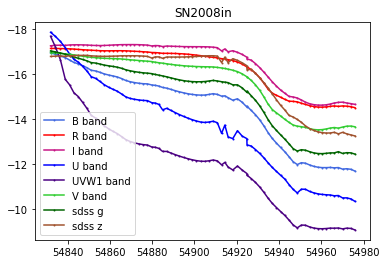

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


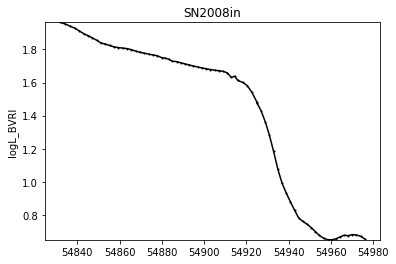

SN2009bb
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


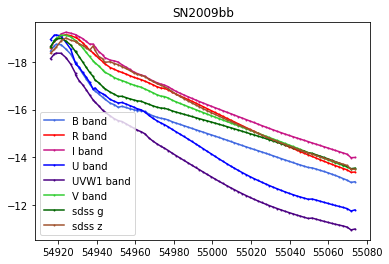

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


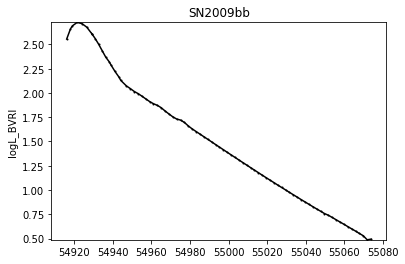

SN2009bw
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


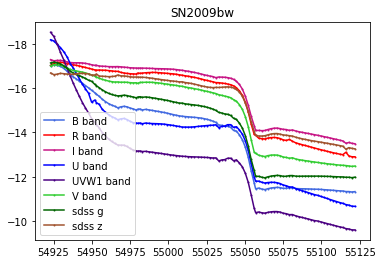

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


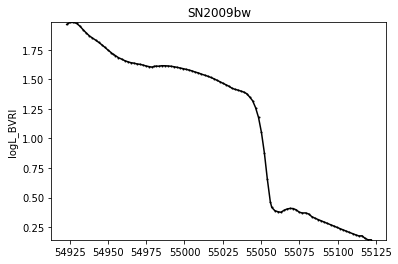

SN2009dd
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


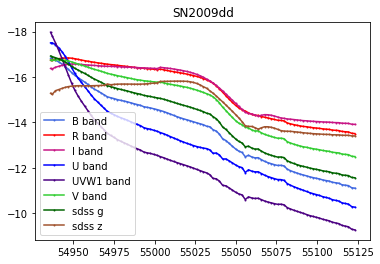

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


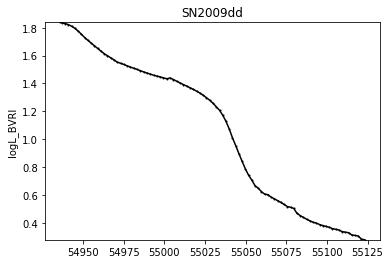

SN2009ib
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


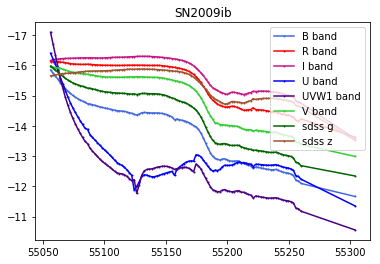

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


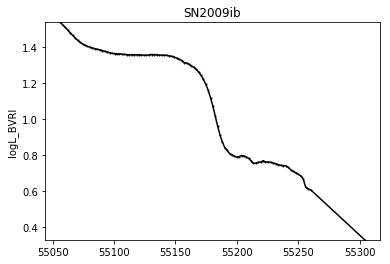

SN2009ip
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


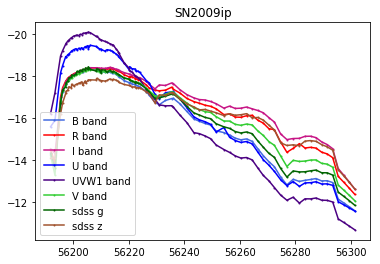

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


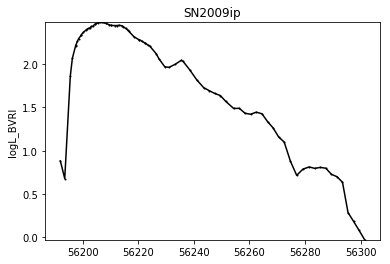

SN2009iz
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


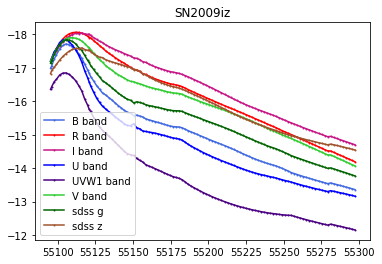

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


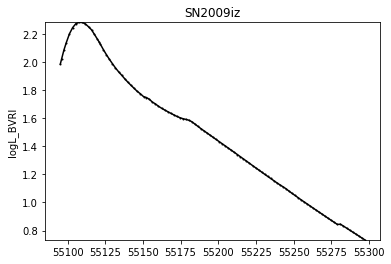

SN2009jf
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


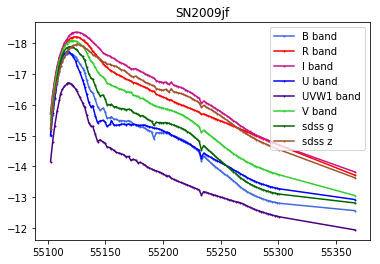

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


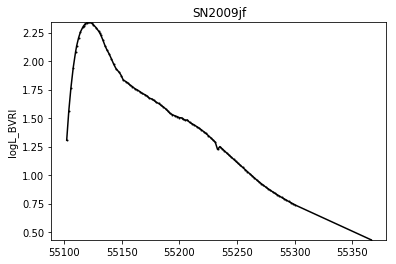

SN2009kr
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


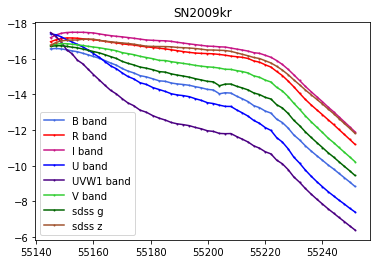

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


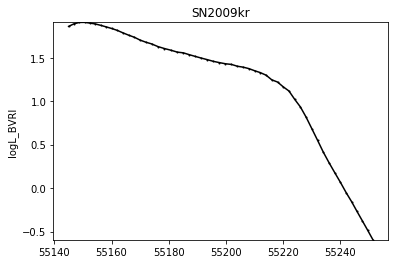

SN2009N
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


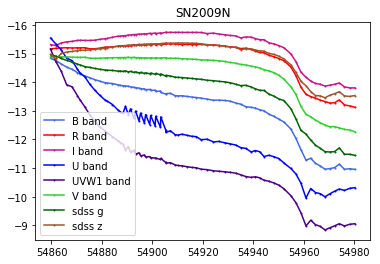

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


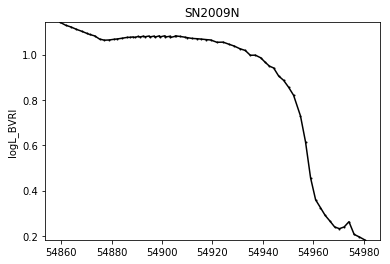

SN2010al
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


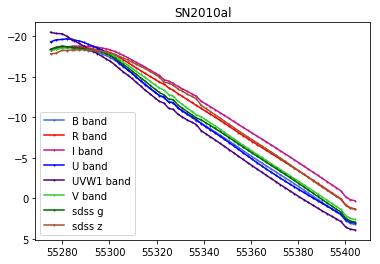

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


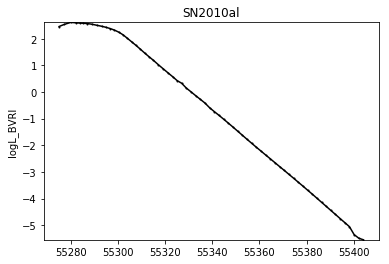

SN2011bm
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


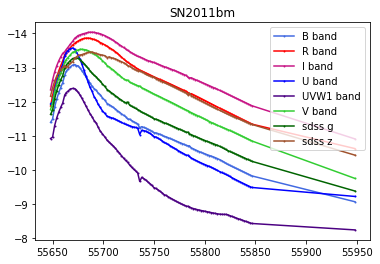

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


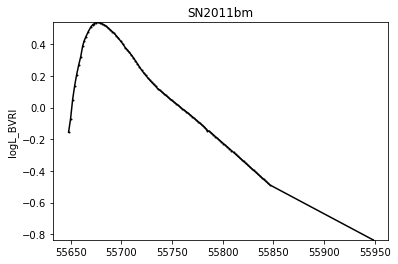

SN2011dh
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


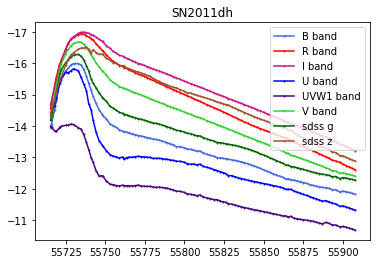

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


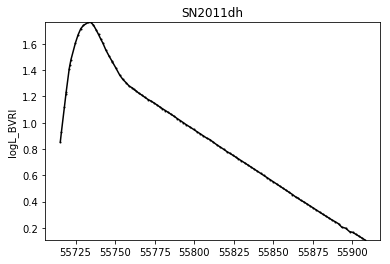

SN2011ei
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


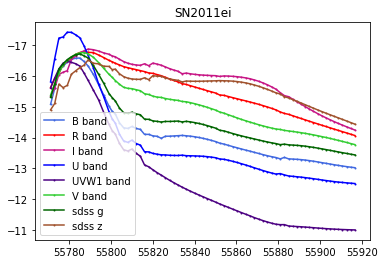

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


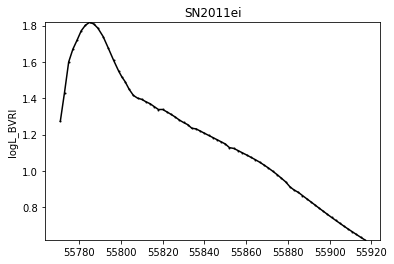

SN2011fu
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


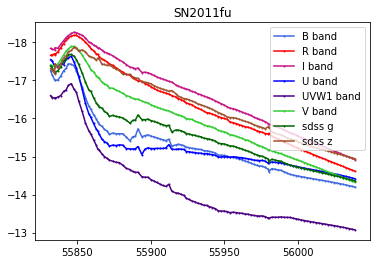

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


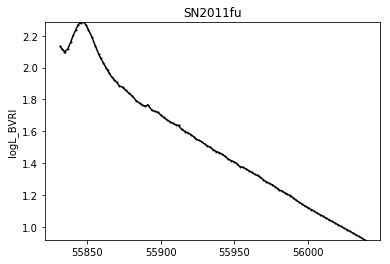

SN2011hs
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


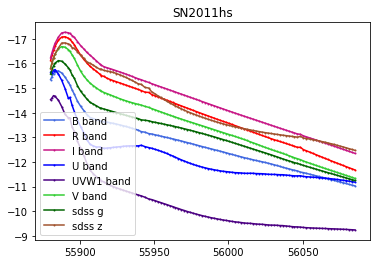

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


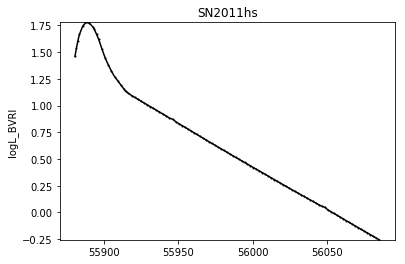

SN2011ht
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


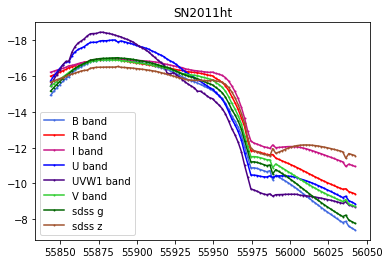

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


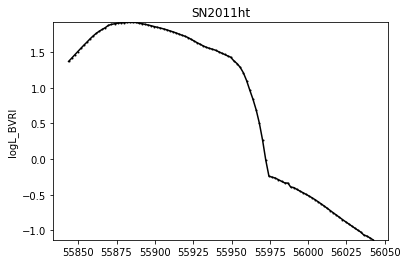

SN2012A
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


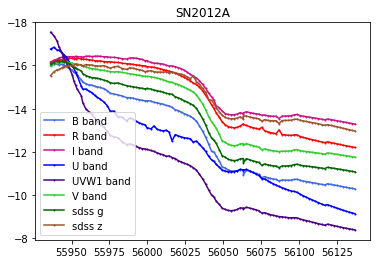

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


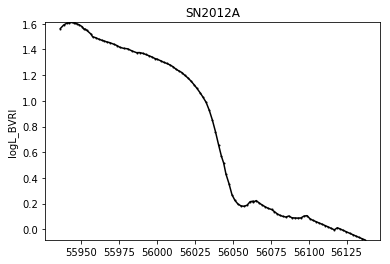

SN2012ap
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


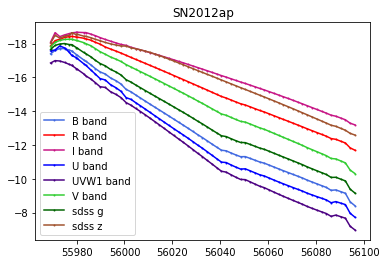

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


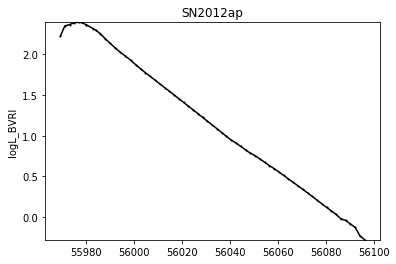

SN2012aw
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


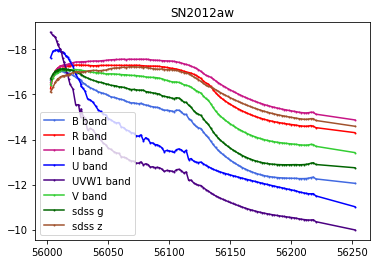

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


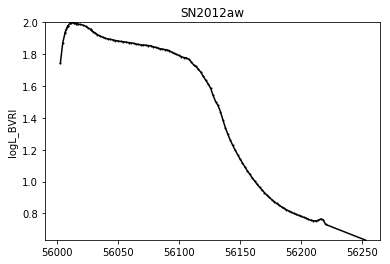

SN2013ab
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


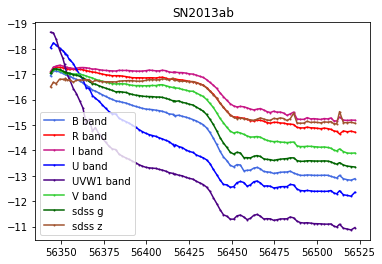

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


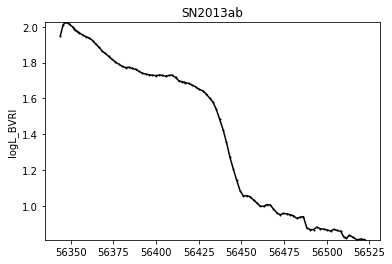

SN2013am
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


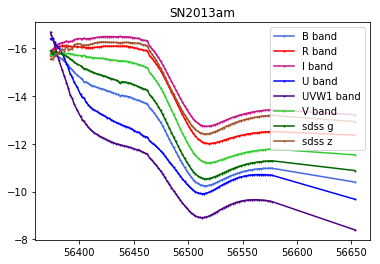

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


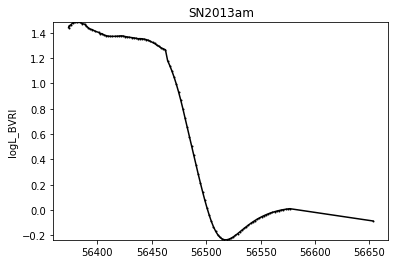

SN2013by
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


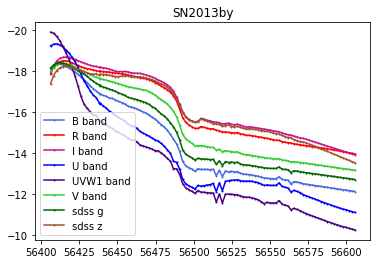

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


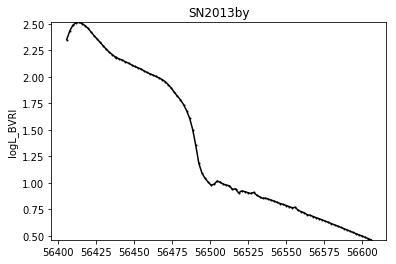

SN2013df
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


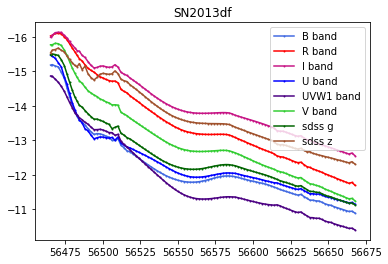

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


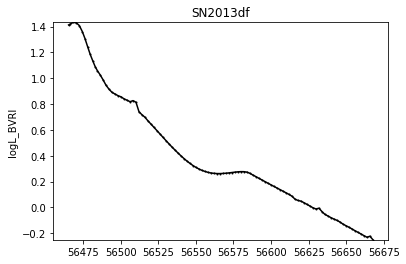

SN2013ej
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


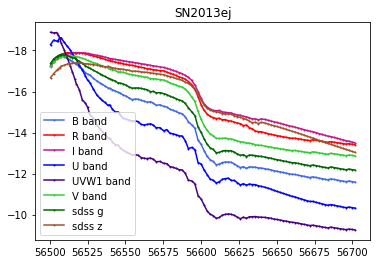

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


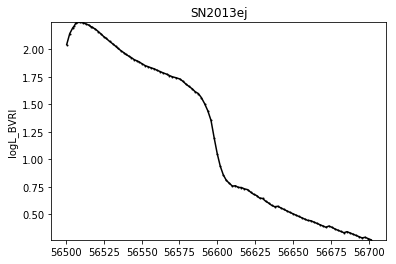

SN2013fs
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


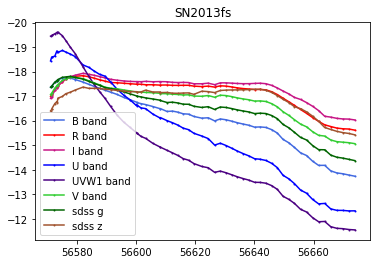

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


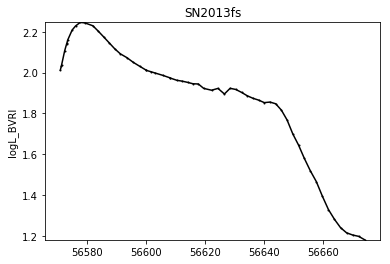

SN2013ge
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


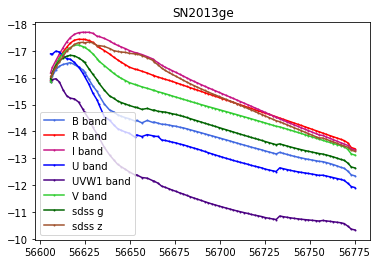

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


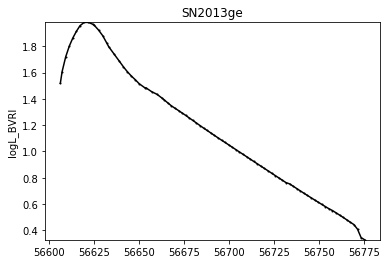

SN2014G
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


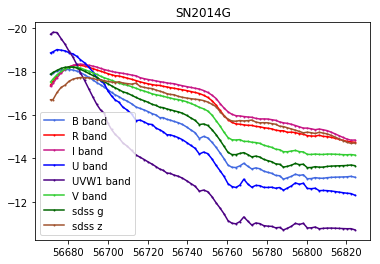

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


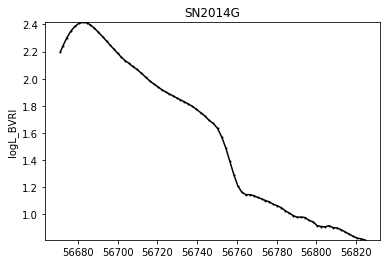

SN2016bkv
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


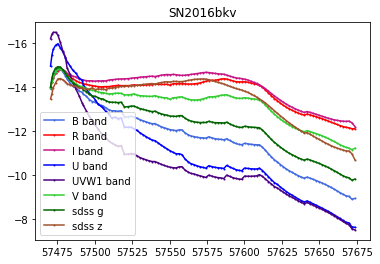

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


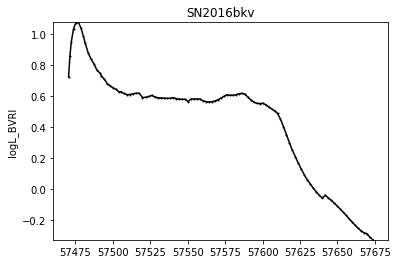

SN2016gkg
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


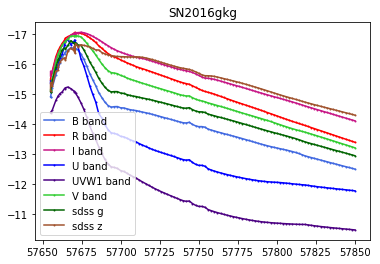

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


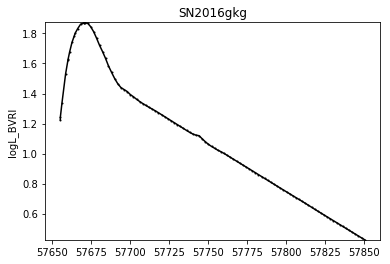

SN2016X
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


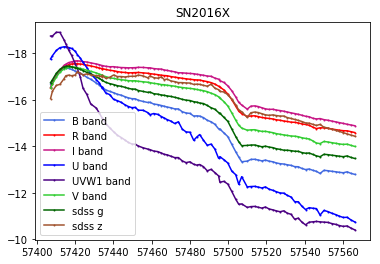

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


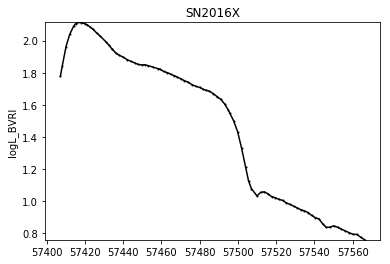

SN2012au
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


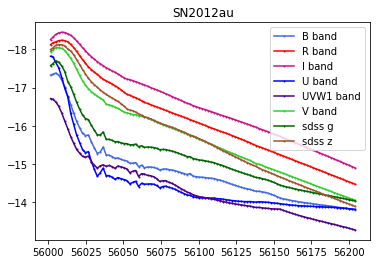

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


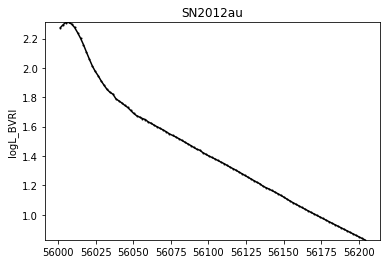

In [11]:
var = 'mag'

for snname in sn_list:#['SN2007uy','SN2009kr','SN2007pk','SN1994I','SN2008aq','SN2005bf']:
    print (snname)
    
    fig = plt.figure(1)
    # B BAND
    band = 'Bessell_B'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_B_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='B band')

    # R BAND
    band = 'Bessell_R'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_R_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='R band')
    
    # I BAND
    band = 'Bessell_I'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_I_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='I band')

    band = 'Bessell_U'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_U_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='U band')


    # UVW1 BAND
    band = 'swift_UVW1'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_swift_LC_4LF.csv', index=False)
    
    maxR = max(res['mag'])
    minR = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='UVW1 band')


    # R BAND without HOST extinction!!!!!
    band = 'Bessell_R'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=False)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_R_nohostcorr_LC_4LF.csv', index=False)
    
    #plt.errorbar(res['time'], res[var], 
    #             color='darkred', mfc='darkred', marker='.', ms=2,
    #             ecolor='grey', label='R band with host ext')

    # B BAND without HOST extinction!!!!!
    band = 'Bessell_B'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=False)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_B_nohostcorr_LC_4LF.csv', index=False)
    
    #plt.errorbar(res['time'], res[var], 
    #             color='darkred', mfc='darkred', marker='.', ms=2,
    #             ecolor='grey', label='R band with host ext')


    # V BAND without HOST extinction!!!!!
    band = 'Bessell_V'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=False)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_V_nohostcorr_LC_4LF.csv', index=False)
    
    #plt.errorbar(res['time'], res[var], 
    #             color='darkred', mfc='darkred', marker='.', ms=2,
    #             ecolor='grey', label='R band with host ext')


    # V BAND
    band = 'Bessell_V'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_V_LC_4LF.csv', index=False)
    
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='V band')

    ## g BAND
    band = "sdss_g'"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_gPrime_LC_4LF.csv', index=False)
        
    # r BAND
    band = "sdss_r'"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_rPrime_LC_4LF.csv', index=False)
        

    ## g BAND
    band = "sdss_g"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_g_LC_4LF.csv', index=False)
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='sdss g')

    band = "sdss_z"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_z_LC_4LF.csv', index=False)
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='sdss z')

    plt.legend()
    if var=='mag': plt.gca().invert_yaxis()
    plt.title(snname)
    plt.show()
    fig.savefig('/Users/mariavincenzi/PhD/pycoco_2/final_LC_quick/%s.pdf'%snname, bbox_inches='tight')
    # r BAND
    band = "sdss_r"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_r_LC_4LF.csv', index=False)
                                           
    if notLBvri : pass                                     
    else:
        bands = ['Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
        res_all = pd.DataFrame()
        for band in bands:
            LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
            dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
            res = pd.DataFrame(dicts_LC_gp[band])
            res.columns = ['f_%s'%band, 'ferr_%s'%band, 'time']
            w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
            wtf_b = wtf.Band_Vega(w,t)
            res['f_%s'%band] = res['f_%s'%band].values*wtf_b.areaA()
            res['ferr_%s'%band] = res['ferr_%s'%band].values*wtf_b.areaA()
        #    res['mag_%s'%band] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
        #    res['mag_err_%s'%band] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, 
        #                                                res['flux_err'].values*flux_units)
        #    res['MAG_%s'%band] = (res['mag_%s'%band]-LC.dist_mod()).values
            if len(res_all)==0:
                res_all = res[['time', 'f_%s'%band, 'ferr_%s'%band]]
            else:
                res_all = pd.merge(res_all, res[['time', 'f_%s'%band, 'ferr_%s'%band]])
            
        res_all['F'] = res_all['f_Bessell_B'].values +\
                    res_all['f_Bessell_V'].values +\
                    res_all['f_Bessell_R'].values +\
                    res_all['f_Bessell_I'].values
        res_all['F_err'] = ((res_all['ferr_Bessell_B'].values)**2 +\
                        (res_all['ferr_Bessell_V'].values)**2 +\
                        (res_all['ferr_Bessell_R'].values)**2 +\
                        (res_all['ferr_Bessell_I'].values)**2)**0.5
        res_all['logL_BVRI'] = np.log10(res_all['F'])#*LC.Ftof())
        res_all['logL_BVRI_err'] = 1./np.log(10.)*(res_all['F_err']/res_all['F'])
        
        plt.errorbar(res_all['time'], res_all['logL_BVRI'], #res_all['logL_BVRI_err'], 
                     marker='.', ms=2, color='k', ecolor='k')
        try:
            plt.ylim(min(res_all['logL_BVRI']), max(res_all['logL_BVRI']))
        except: pass
        plt.ylabel('logL_BVRI')
        plt.title(snname)
        plt.show()
    
        res_all[['time', 'logL_BVRI', 'logL_BVRI_err']].to_csv(LC.results_mainpath+'Bessell_BVRI_LC_4LF.csv', index=False)

ASASSN14jb
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


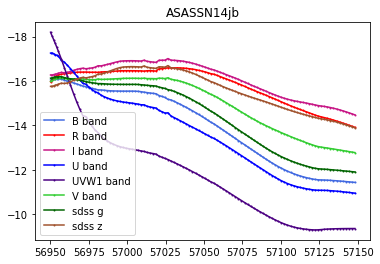

Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)
Computing GP fit (for the first time)


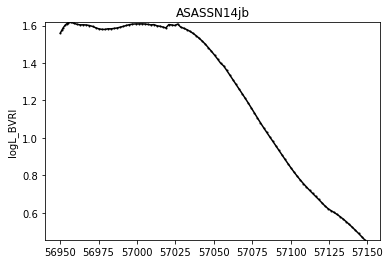

In [13]:
var = 'mag'

for snname in ['ASASSN14jb']:#['SN2007uy','SN2009kr','SN2007pk','SN1994I','SN2008aq','SN2005bf']:
    print (snname)
    
    fig = plt.figure(1)
    # B BAND
    band = 'Bessell_B'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_B_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='B band')

    # R BAND
    band = 'Bessell_R'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_R_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='R band')
    
    # I BAND
    band = 'Bessell_I'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_I_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='I band')

    band = 'Bessell_U'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_U_LC_4LF.csv', index=False)
    maxB = max(res['mag'])
    minB = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='U band')


    # UVW1 BAND
    band = 'swift_UVW1'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_swift_LC_4LF.csv', index=False)
    
    maxR = max(res['mag'])
    minR = min(res['mag'])
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='UVW1 band')


    # R BAND without HOST extinction!!!!!
    band = 'Bessell_R'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=False)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_R_nohostcorr_LC_4LF.csv', index=False)
    
    #plt.errorbar(res['time'], res[var], 
    #             color='darkred', mfc='darkred', marker='.', ms=2,
    #             ecolor='grey', label='R band with host ext')

    # B BAND without HOST extinction!!!!!
    band = 'Bessell_B'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=False)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_B_nohostcorr_LC_4LF.csv', index=False)
    
    #plt.errorbar(res['time'], res[var], 
    #             color='darkred', mfc='darkred', marker='.', ms=2,
    #             ecolor='grey', label='R band with host ext')


    # V BAND without HOST extinction!!!!!
    band = 'Bessell_V'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True, hostcorr=False)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_V_nohostcorr_LC_4LF.csv', index=False)
    
    #plt.errorbar(res['time'], res[var], 
    #             color='darkred', mfc='darkred', marker='.', ms=2,
    #             ecolor='grey', label='R band with host ext')


    # V BAND
    band = 'Bessell_V'
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_V_LC_4LF.csv', index=False)
    
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='V band')

    ## g BAND
    band = "sdss_g'"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_gPrime_LC_4LF.csv', index=False)
        
    # r BAND
    band = "sdss_r'"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_rPrime_LC_4LF.csv', index=False)
        

    ## g BAND
    band = "sdss_g"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_g_LC_4LF.csv', index=False)
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='sdss g')

    band = "sdss_z"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_z_LC_4LF.csv', index=False)
    plt.errorbar(res['time'], res[var], 
                 color=color_dict[band], mfc=color_dict[band], marker='.', ms=2,
                 ecolor='grey', label='sdss z')

    plt.legend()
    if var=='mag': plt.gca().invert_yaxis()
    plt.title(snname)
    plt.show()
    fig.savefig('/Users/mariavincenzi/PhD/pycoco_2/final_LC_quick/%s.pdf'%snname, bbox_inches='tight')
    # r BAND
    band = "sdss_r"
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_AB(w,t)
    res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
    res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
    #res['MAG'] = (res['mag']-LC.dist_mod()).values
    res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_r_LC_4LF.csv', index=False)
                                           
    if notLBvri : pass                                     
    else:
        bands = ['Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
        res_all = pd.DataFrame()
        for band in bands:
            LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
            dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
            res = pd.DataFrame(dicts_LC_gp[band])
            res.columns = ['f_%s'%band, 'ferr_%s'%band, 'time']
            w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
            wtf_b = wtf.Band_Vega(w,t)
            res['f_%s'%band] = res['f_%s'%band].values*wtf_b.areaA()
            res['ferr_%s'%band] = res['ferr_%s'%band].values*wtf_b.areaA()
        #    res['mag_%s'%band] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
        #    res['mag_err_%s'%band] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, 
        #                                                res['flux_err'].values*flux_units)
        #    res['MAG_%s'%band] = (res['mag_%s'%band]-LC.dist_mod()).values
            if len(res_all)==0:
                res_all = res[['time', 'f_%s'%band, 'ferr_%s'%band]]
            else:
                res_all = pd.merge(res_all, res[['time', 'f_%s'%band, 'ferr_%s'%band]])
            
        res_all['F'] = res_all['f_Bessell_B'].values +\
                    res_all['f_Bessell_V'].values +\
                    res_all['f_Bessell_R'].values +\
                    res_all['f_Bessell_I'].values
        res_all['F_err'] = ((res_all['ferr_Bessell_B'].values)**2 +\
                        (res_all['ferr_Bessell_V'].values)**2 +\
                        (res_all['ferr_Bessell_R'].values)**2 +\
                        (res_all['ferr_Bessell_I'].values)**2)**0.5
        res_all['logL_BVRI'] = np.log10(res_all['F'])#*LC.Ftof())
        res_all['logL_BVRI_err'] = 1./np.log(10.)*(res_all['F_err']/res_all['F'])
        
        plt.errorbar(res_all['time'], res_all['logL_BVRI'], #res_all['logL_BVRI_err'], 
                     marker='.', ms=2, color='k', ecolor='k')
        try:
            plt.ylim(min(res_all['logL_BVRI']), max(res_all['logL_BVRI']))
        except: pass
        plt.ylabel('logL_BVRI')
        plt.title(snname)
        plt.show()
    
        res_all[['time', 'logL_BVRI', 'logL_BVRI_err']].to_csv(LC.results_mainpath+'Bessell_BVRI_LC_4LF.csv', index=False)

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(6000, 10000)

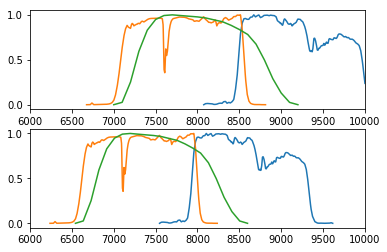

In [68]:
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('DES', 'DES_z'))
plt.subplot(211)
plt.plot(w,t)
plt.subplot(212)
plt.plot(w/(1+0.07),t)
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('DES', 'DES_i'))
plt.subplot(211)
plt.plot(w,t)
plt.xlim(6000,10000)
plt.subplot(212)
plt.plot(w/(1+0.07),t)
plt.xlim(6000,10000)

w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', 'Bessell_I'))
plt.subplot(211)
plt.plot(w,t)
plt.xlim(6000,10000)
plt.subplot(212)
plt.plot(w/(1+0.07),t)
plt.xlim(6000,10000)



/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


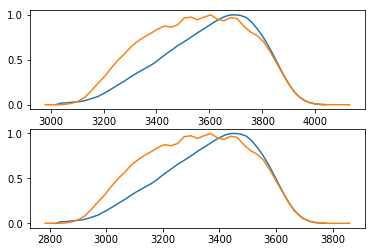

In [83]:
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.txt'%('Site3_CSP', "sdss_u'"))
plt.subplot(211)
plt.plot(w,t)
plt.subplot(212)
plt.plot(w/(1+0.07),t)

w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', "sdss_u'"))
plt.subplot(211)
plt.plot(w,t)
plt.subplot(212)
plt.plot(w/(1+0.07),t)

In [19]:
# Measure peaks
snname = 'SN2009mg'

In [59]:
band = 'Bessell_B'
LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
res = pd.DataFrame(dicts_LC_gp[band])
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
wtf_b = wtf.Band_Vega(w,t)



Computing GP fit (for the first time)
Bessell_B [0.00102939]


Computing GP fit (for the first time)
Bessell_B [0.00102939]
Computing GP fit (for the first time)
Bessell_R [0.00512774]


<ErrorbarContainer object of 3 artists>

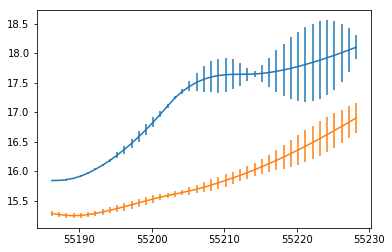

In [60]:
#figure = plt.figure(10, figsize=(6,3))


## B BAND
band = 'Bessell_B'
LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
res = pd.DataFrame(dicts_LC_gp[band])
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
wtf_b = wtf.Band_Vega(w,t)
res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_B_LC_4LF.csv', index=False)

plt.errorbar(res['time'], res['mag'], res['mag_err'], label='B band')

# R BAND
band = 'Bessell_R'
LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
res = pd.DataFrame(dicts_LC_gp[band])
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
wtf_b = wtf.Band_Vega(w,t)
res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'Bessell_R_LC_4LF.csv', index=False)

plt.errorbar(res['time'], res['mag'], res['mag_err'], label='R band')

#plt.legend()
#plt.title(snname)
##plt.ylim( -14, -18.5)
#figure.savefig(LC.results_mainpath+'LC_4LF.png')
#plt.show()
#plt.close()



Computing GP fit (for the first time)
sdss_g' [0.00100014]
Computing GP fit (for the first time)
sdss_r' [0.00459076]


<ErrorbarContainer object of 3 artists>

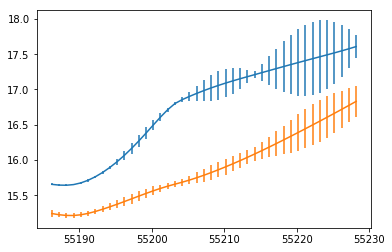

In [61]:
#figure = plt.figure(10, figsize=(6,3))


## g BAND
band = "sdss_g'"
LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
res = pd.DataFrame(dicts_LC_gp[band])
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
wtf_b = wtf.Band_Vega(w,t)
res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_gPrime_LC_4LF.csv', index=False)

plt.errorbar(res['time'], res['mag'], res['mag_err'], label='g band')

# r BAND
band = "sdss_r'"
LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
res = pd.DataFrame(dicts_LC_gp[band])
w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
wtf_b = wtf.Band_Vega(w,t)
res['mag'] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
res['mag_err'] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, res['flux_err'].values*flux_units)
res[['time', 'mag', 'mag_err']].to_csv(LC.results_mainpath+'sdss_rPrime_LC_4LF.csv', index=False)

plt.errorbar(res['time'], res['mag'], res['mag_err'], label='r band')

#plt.legend()
#plt.title(snname)
##plt.ylim( -14, -18.5)
#figure.savefig(LC.results_mainpath+'LC_4LF.png')
#plt.show()
#plt.close()


In [62]:
bands = ['Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I']
res_all = pd.DataFrame()
for band in bands:
    LC = GenerateLC(main_path=DATALC_PATH, snname=snname, twodim=True)
    dicts_LC_gp = LC.LCfit_withGP(f_list=[band]) 
    res = pd.DataFrame(dicts_LC_gp[band])
    res.columns = ['f_%s'%band, 'ferr_%s'%band, 'time']
    w,t = wtf.loadFilter(FILTER_PATH+'%s/%s.dat'%('GeneralFilters', band))
    wtf_b = wtf.Band_Vega(w,t)
    res['f_%s'%band] = res['f_%s'%band].values*wtf_b.areaA()
    res['ferr_%s'%band] = res['ferr_%s'%band].values*wtf_b.areaA()
#    res['mag_%s'%band] = wtf.flux2mag(wtf_b, res['flux'].values*flux_units)
#    res['mag_err_%s'%band] = wtf.ERRflux2ERRmag(wtf_b, res['flux'].values*flux_units, 
#                                                res['flux_err'].values*flux_units)
#    res['MAG_%s'%band] = (res['mag_%s'%band]-LC.dist_mod()).values
    if len(res_all)==0:
        res_all = res[['time', 'f_%s'%band, 'ferr_%s'%band]]
    else:
        res_all = pd.merge(res_all, res[['time', 'f_%s'%band, 'ferr_%s'%band]])

Computing GP fit (for the first time)
Bessell_B [0.00102939]
Computing GP fit (for the first time)
Bessell_V [0.0010295]
Computing GP fit (for the first time)
Bessell_R [0.00512774]
Computing GP fit (for the first time)
Bessell_I [0.02209898]


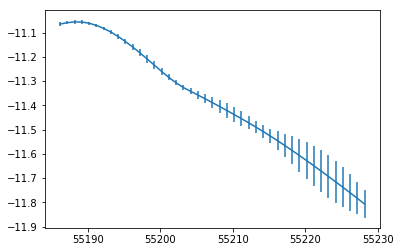

In [63]:
res_all['F'] = res_all['f_Bessell_B'].values +\
                res_all['f_Bessell_V'].values +\
                res_all['f_Bessell_R'].values +\
                res_all['f_Bessell_I'].values
res_all['F_err'] = ((res_all['ferr_Bessell_B'].values)**2 +\
                (res_all['ferr_Bessell_V'].values)**2 +\
                (res_all['ferr_Bessell_R'].values)**2 +\
                (res_all['ferr_Bessell_I'].values)**2)**0.5
res_all['logL_BVRI'] = np.log10(res_all['F'])
res_all['logL_BVRI_err'] = 1./np.log(10.)*(res_all['F_err']/res_all['F'])

plt.errorbar(res_all['time'], res_all['logL_BVRI'], res_all['logL_BVRI_err'], label='R band')

res_all[['time', 'logL_BVRI', 'logL_BVRI_err']].to_csv(LC.results_mainpath+'Bessell_BVRI_LC_4LF.csv', index=False)

In [66]:
LC.Ftof(), res_all['F'][:10], res_all['F'][:10]*LC.Ftof().value

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:214: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


(<Quantity 1.25495926e+53 cm2>, 0    8.606348e-12
 1    8.722692e-12
 2    8.783338e-12
 3    8.771815e-12
 4    8.674449e-12
 5    8.499463e-12
 6    8.261388e-12
 7    7.973339e-12
 8    7.647328e-12
 9    7.294805e-12
 Name: F, dtype: float64, 0    1.080062e+42
 1    1.094662e+42
 2    1.102273e+42
 3    1.100827e+42
 4    1.088608e+42
 5    1.066648e+42
 6    1.036771e+42
 7    1.000622e+42
 8    9.597085e+41
 9    9.154684e+41
 Name: F, dtype: float64)

In [57]:
LC.Ftof(), res_all['F'][:10]

/Users/mariavincenzi/anaconda2_7/envs/myenv/lib/python3.4/site-packages/ipykernel/__main__.py:214: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


(<Quantity 4.42434477e+52 cm2>, 0     7.660857
 1    11.658958
 2    16.363846
 3    21.923657
 4    28.089445
 5    34.510598
 6    40.931888
 7    46.987544
 8    52.446837
 9    57.129988
 Name: F, dtype: float64)

In [ ]:
LC.Ftof(), res_all['F'][:10]

In [24]:
import sncosmo

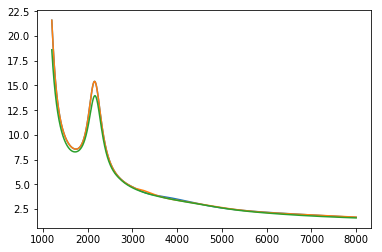

In [25]:
CCM = sncosmo.CCM89Dust()
OD = sncosmo.OD94Dust()
FF = sncosmo.F99Dust()

eb_v = 0.3

ww = np.arange(1200.,8000., 1)

CCM.parameters = [eb_v, 3.1]
d = CCM.propagate(ww, np.ones(len(ww)))
plt.plot(ww,1./d)
OD.parameters = [eb_v, 3.1]
d = OD.propagate(ww, np.ones(len(ww)))
plt.plot(ww,1./d)
FF.parameters = [eb_v]
d = FF.propagate(ww, np.ones(len(ww)))
plt.plot(ww,1./d)



In [26]:
FF.parameters

array([0.3])